In [2]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import modisco.visualization.viz_sequence as viz_sequence
import h5py
import numpy as np
import tqdm
tqdm.tqdm_notebook()

|<bar/>| 0/? [00:00<?, ?it/s]

In [3]:
# Path to SHAP scores and TF-MoDISco results
base_path = "/mnt/lab_data2/amtseng/tfmodisco/results/FROM_NAUTILUS/results/shap_scores"
shap_scores_path = os.path.join(base_path, "GABPA/GABPA_shap_scores_fold7.h5")

In [4]:
with h5py.File(shap_scores_path, "r") as f:
    hyp_scores = f["hyp_scores"][:]
    input_seqs = f["input_seqs"][:]

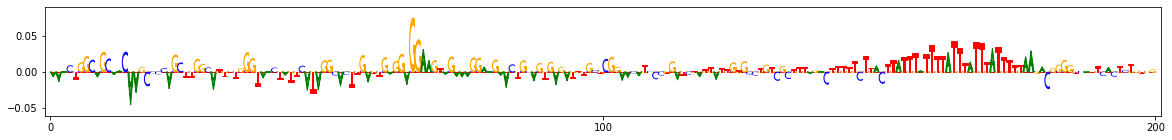

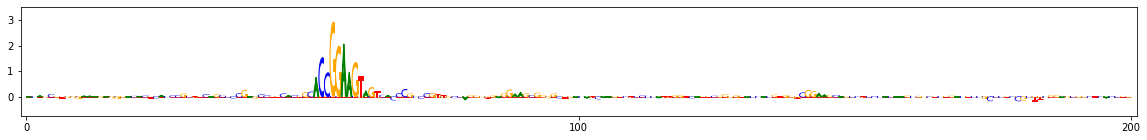

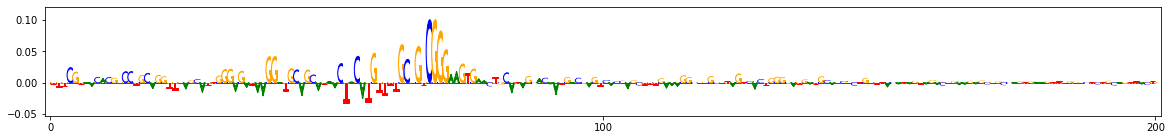

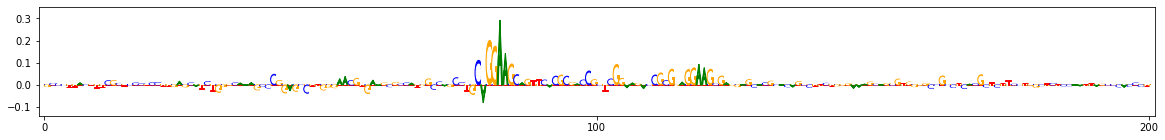

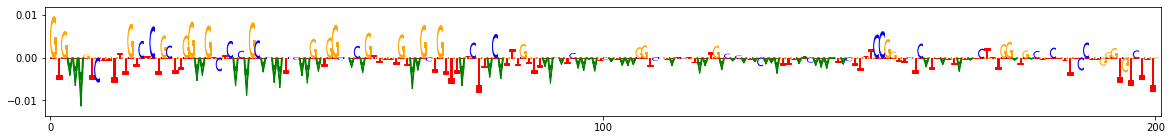

In [5]:
for index in np.random.choice(hyp_scores.shape[0], size=5, replace=False):
    viz_sequence.plot_weights((hyp_scores[index] * input_seqs[index])[570:770], subticks_frequency=100)

In [7]:
background_freqs = np.array([0.27, 0.23, 0.23, 0.27])
def info_content(track, pseudocount=0.001):
    """
    Given an L x 4 track, computes information content for each base and
    returns it as an L-array.
    """
    num_bases = track.shape[1]
    # Normalize track to probabilities along base axis
    track_norm = (track + pseudocount) / (np.sum(track, axis=1, keepdims=True) + (num_bases * pseudocount))
    ic = track_norm * np.log2(track_norm / np.expand_dims(background_freqs, axis=0))
    return np.sum(ic, axis=1)

In [4]:
def import_tfmodisco_motifs(
    tfm_results_hdf5, min_seqlets=750, min_ic=0.8, ic_window=6, trim_flank_ic_frac=0.2,
    plot_all_motifs=False, plot_passed_motifs=True
):
    """
    Imports the TF-MoDISco motifs, and returns a list of motifs, trimmed by info content.
    The motifs returned must have at least `min_seqlets` supporting them, and there must
    be a window of size `ic_window` with at IC at least `min_ic`. Finally, the resulting
    motifs are trimmed by cutting off flanks whose base-level IC is below
    `trim_flank_ic_frac` of the highest IC of the motif. This also only keeps motifs with
    overall positive contributions (i.e. no negative seqlets).
    """
    motifs = []
    with h5py.File(tfm_results_hdf5, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if plot_all_motifs:
                print("Metacluster: %s (%d/%d)" % (metacluster_key, metacluster_i + 1, num_metaclusters))
                print("==========================================")
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name.decode()
                pattern = patterns[pattern_name]
                seqlets = pattern["seqlets_and_alnmts"]["seqlets"]
                
                if plot_all_motifs:
                    print("Pattern: %s (%d/%d)" % (pattern_name, pattern_i + 1, num_patterns))
                    print("--------------------------------------")

                    print("%d seqlets" % len(seqlets))
                    print("Sequence")
                    viz_sequence.plot_weights(pattern["sequence"]["fwd"][:])
                    print("Hypothetical contributions")
                    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"][:])
                    print("Contribution_scores")
                    viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"][:])
                
                pwm = pattern["sequence"]["fwd"][:]
                act_contribs = pattern["task0_contrib_scores"]["fwd"][:]
                
                # Check that the contribution scores are overall positive
                if np.sum(act_contribs) < 0:
                    continue
                
                # Check number of seqlets and IC
                if len(seqlets) < min_seqlets:
                    continue
                
                pwm_ic = info_content(pwm)
                max_windowed_ic = max(
                    np.sum(pwm_ic[i : (i + ic_window)]) for i in range(len(pwm_ic) - ic_window + 1)
                )
                if max_windowed_ic / ic_window < min_ic:
                    continue
                    
                # Cut off flanks from actual contribution scores based on IC of PWM
                ic_trim_thresh = np.max(pwm_ic) * trim_flank_ic_frac
                pass_inds = np.where(pwm_ic >= ic_trim_thresh)[0]
                trimmed_motif = act_contribs[
                    np.min(pass_inds): np.max(pass_inds) + 1
                ]
                motifs.append(trimmed_motif)
                
    if plot_passed_motifs:
        print("Final motifs: %d total" % len(motifs))
        print("==========================================")
        for motif in motifs:
            viz_sequence.plot_weights(motif)
    return motifs

Metacluster: metacluster_0 (1/2)
Pattern: pattern_0 (1/12)
--------------------------------------
476 seqlets
Sequence


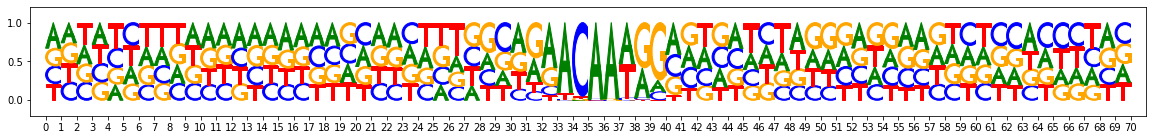

Hypothetical contributions


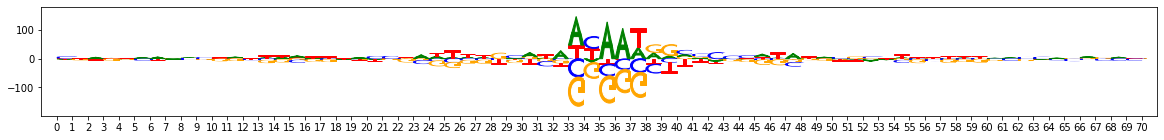

Contribution_scores


KeyboardInterrupt: 

In [5]:
motifs = import_tfmodisco_motifs(tfm_results_path, plot_all_motifs=True, plot_passed_motifs=True)

Final motifs: 2 total


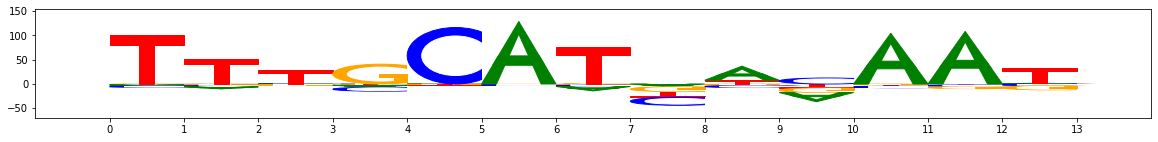

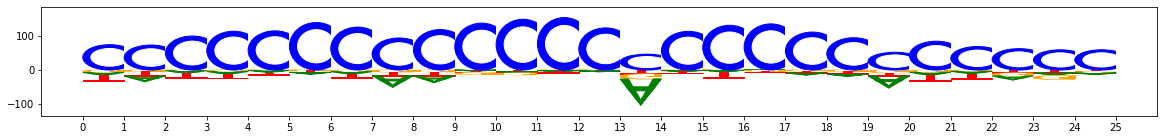

In [8]:
motifs = import_tfmodisco_motifs(tfm_results_path, plot_all_motifs=False, plot_passed_motifs=True)

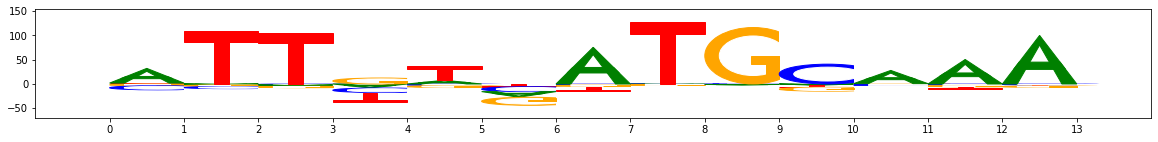

In [10]:
viz_sequence.plot_weights(np.flip(motifs[0], axis=(0, 1)))